In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from src import orbits as orb
from Utilities import sections as sec
from scipy.integrate import odeint
import os
from Utilities.basic_units import radians

from Utilities.operators import make_tree, to_cylindric, Ryan_sampler
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

<Figure size 800x600 with 0 Axes>

In [2]:
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
check = 'Low' # 'Low' or 'HiRes' or 'Res20'
folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}'
snap = '164'
path = f'TDE/{folder}{check}/{snap}'
saving_path = f'Figs/{folder}/{check}'
print(f'We are in: {path}, \nWe save in: {saving_path}')
is_tde = True

Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp
apo = Rt**2 / Rstar #2 * Rt * (Mbh/mstar)**(1/3)

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2

theta_lim = 3/4 * np.pi
step = 0.02
theta_init = np.arange(-theta_lim, theta_lim, step)
theta_arr = Ryan_sampler(theta_init)

We are in: TDE/R0.47M0.5BH10000beta1S60n1.5Low/164, 
We save in: Figs/R0.47M0.5BH10000beta1S60n1.5/Low


In [24]:
def find_sz_plane(theta_data, r_data, z_data, f_data, theta_orbit, r_orbit, a = Rp, arc_length = False):
    """
    Parameters
    --------
    theta_data, r_data, z_data, f_data: array.
        (ALL) Simulation cells' values of THETA_cyl, R_cyl, Z, quantity f.
    theta_orbit, r_orbit: array.
        Orbit's angles/radii.
    Returns
    --------
    f_sz, z_sz, theta_broadcast: array.
        (Broadcasted) profile of f (and the corresponding height) for each point on the orbit
    """
    f_sz = []
    z_sz = []
    for i,theta in enumerate(theta_orbit):
        condition_theta = np.abs(theta-theta_data)<0.1
        condition_r = np.abs(r_orbit[i]-r_data)<0.1
        condition = np.logical_and(condition_theta, condition_r)
        f_sz.append(f_data[condition])
        z_sz.append(z_data[condition])

    # Broadcast so that then you can easily plot
    length = np.zeros(len(z_sz))
    for i in range(len(z_sz)):
        length[i] = int(len(z_sz[i]))
    theta_broadcast = np.repeat(theta_orbit, list(length))
    f_sz = np.concatenate(f_sz)
    z_sz = np.concatenate(z_sz)

    if arc_length:
        s_data = orb.find_arclenght(theta_orbit, r_orbit)
        s_broadcast = np.repeat(s_data, list(length))
        return f_sz, z_sz, theta_broadcast, s_broadcast
    else:
        return f_sz, z_sz, theta_broadcast
    
def Nick_fall(z0, theta, b = beta):
    zE = 1/b * 2*np.sin(theta) / (1+np.cos(theta))
    zF = 1/b * 2*np.cos(theta) / (1+np.cos(theta))
    E = -z0 * np.sqrt(b-1)
    F = z0
    return E*zE + F*zF 

Load data

In [25]:
data = make_tree(path, snap, is_tde, energy = False)
streamL = np.load(f'data/{folder}/stream_{check}{snap}_{step}.npy')
indeces_orbit = streamL[1].astype(int)

R = np.sqrt(data.X**2 + data.Y**2 + data.Z**2)
THETA, RADIUS_cyl = to_cylindric(data.X, data.Y)
r_orbit = RADIUS_cyl[indeces_orbit]
V = np.sqrt(data.VX**2 + data.VY**2 + data.VZ**2)
dim_cell = data.Vol**(1/3) # according to Elad
tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

days after disruption: 1.3532153925058021 // t_fall: 2.5777261297507925 // sim_time: 73.40236449912129


In [26]:
# Cross section at midplane
midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, VX_midplane, VY_midplane, VZ_midplane, Mass_midplane, Den_midplane, Press_midplane, Temp_midplane = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.VX, data.VY, data.VZ, data.Mass, data.Den, data.Press, data.Temp], midplane)

In [27]:
Den_sz, Z_sz, theta_broad = find_sz_plane(THETA, RADIUS_cyl, data.Z, data.Den, theta_arr, r_orbit)

In [28]:
z_arr = np.arange(-1, 1, .2)
free_fall = []
for i,z0 in enumerate(z_arr):
    z = Nick_fall(z0, theta_arr)
    free_fall.append(z)

(-5.0, 5.0)

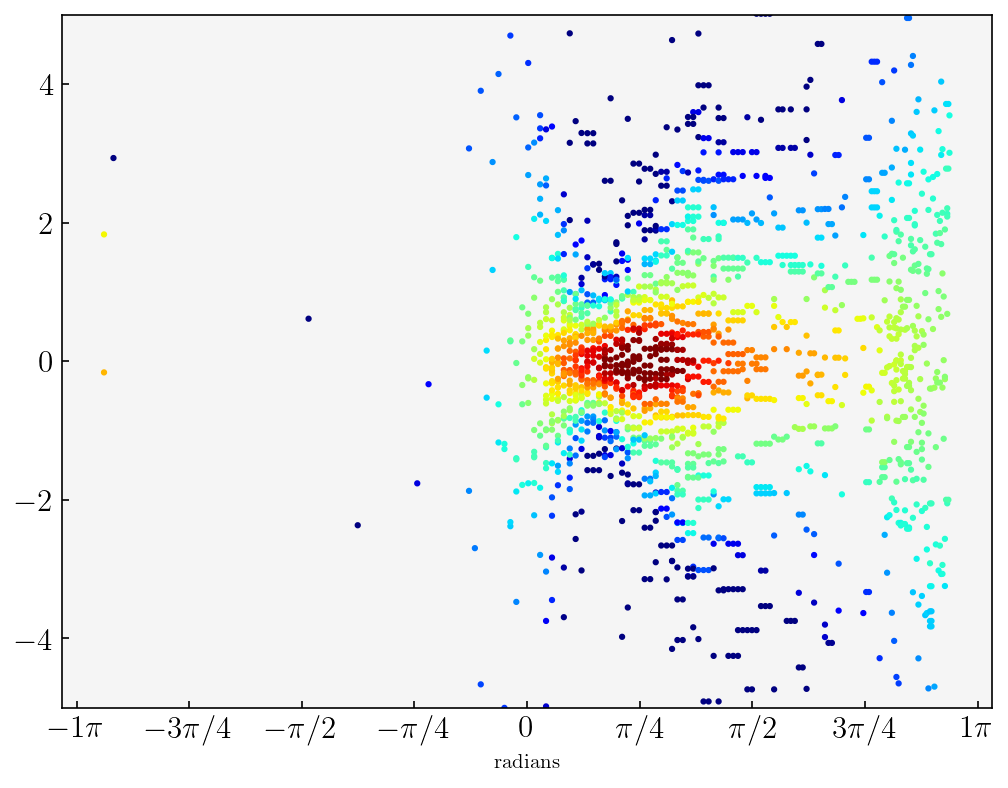

In [29]:
# img = plt.scatter(THETA * radians, Z_sz, c = np.log10(Den_sz), xunits = radians, s= 4, cmap = 'jet', vmin = -12, vmax = -7.5)
plt.ylim(-5,5)

Text(0.5, 0, '$\\theta$')

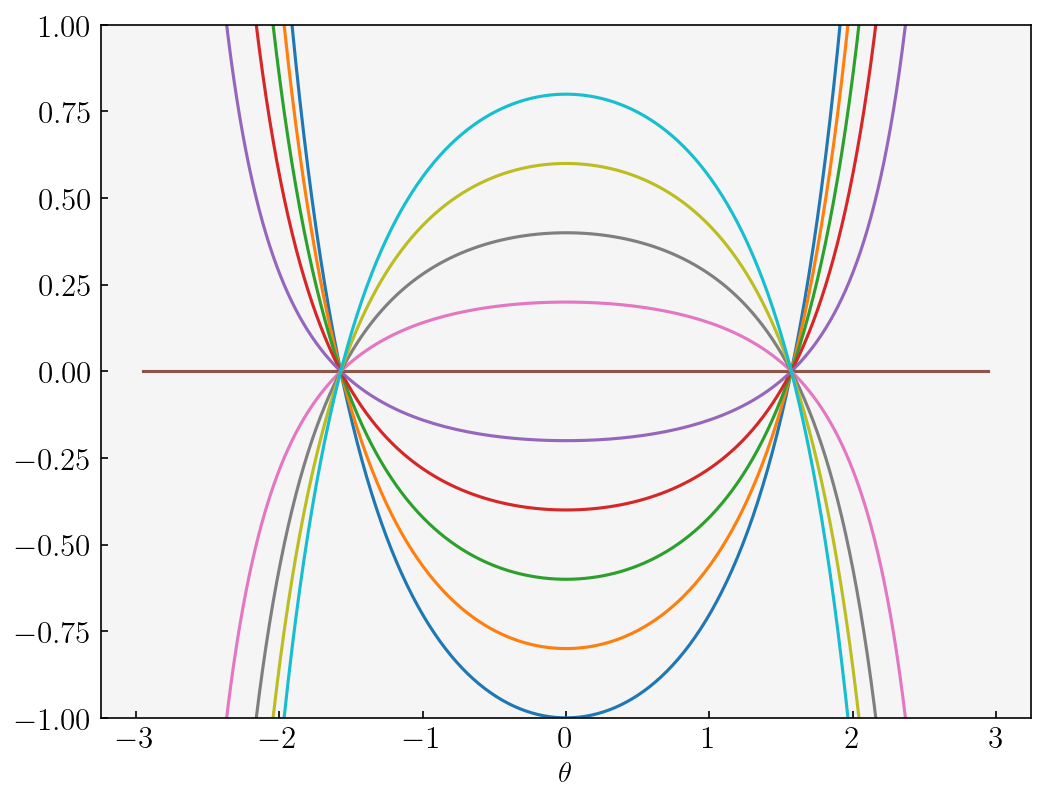

In [30]:
for i in range(len(z_arr)):
    plt.plot(theta_arr, free_fall[i])
plt.ylim(-1,1)
plt.xlabel(r'$\theta$', fontsize = 14)